<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_QPE(MolecularGeometry)_mkbahk_20260123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install qiskit-algorithms==0.3.1
%pip install qiskit-nature[pyscf]==0.7.2
#!pip install pyscf==2.6.0
%pip install py3Dmol

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import numpy as np
from scipy.linalg import expm

from qiskit.circuit.library import UnitaryGate
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import IterativePhaseEstimation
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

In [26]:
# 0.1. 수소분자 정의
# 수소 분자 정의 (원자간 거리: 0.74 Angstrom)
h2 =  "H 0.0 0.0 0.0; H 0.0 0.0 0.74"

# 1. 물분자 H₂O (이미 있으시지만 참고용으로 다시)
h2o = "O 0.000000 0.000000 0.000000; \
       H 0.757000 0.586000 0.000000; \
       H -0.757000 0.586000 0.000000"


# Set up the PySCF driver for the hydrogen atom
driver = PySCFDriver(
    atom=h2,
    basis='sto3g',
    charge=0,
    spin=0  # For neutral H2 molecule (2 electrons), spin should be 0 (singlet) or 2 (triplet)
)

# Run the driver to get the molecular properties
molecule = driver.run()


In [27]:
# Use Jordan-Wigner mapper for fermion-to-qubit mapping
mapper = JordanWignerMapper()

# Get the second-quantized fermionic operator and map it to qubits
fer_op = molecule.hamiltonian.second_q_op()
qubit_op = mapper.map(fer_op)

In [28]:
# Prepare the initial Hartree-Fock state
state_in = HartreeFock(
    num_spatial_orbitals=molecule.num_spatial_orbitals,
    num_particles=molecule.num_particles,
    qubit_mapper=mapper
)

In [29]:
# Set up the Iterative Quantum Phase Estimation (IQPE)
num_iterations = 24  # Number of iterations for precision
sampler = Sampler()  # Use Aer sampler for simulation
iqpe = IterativePhaseEstimation(num_iterations, sampler)

In [30]:
# Create the unitary operator U = exp(i * H)
U = UnitaryGate(expm(1j * qubit_op.to_matrix()))

# Estimate the phase using IQPE
result = iqpe.estimate(U, state_in)

In [31]:
# Compute the ground state energy from the phase
# Phase is in [0, 1), for negative energies, adjust by -1
phase = result.phase
electronic_energy = 2 * np.pi * (phase - 1)

# Add nuclear repulsion energy (0 for single atom)
gs_energy = electronic_energy + molecule.nuclear_repulsion_energy

print("Estimated ground state energy (Hartree):", gs_energy)

Estimated ground state energy (Hartree): -1.1372838222868655


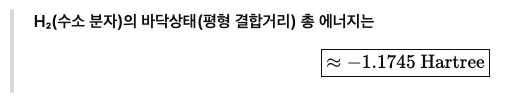